# Power and Connected UEs over Time

This notebook loads:
- Power per PCI over time from `cell_power_changes.csv` and computes a Total Power across PCIs.
- Connected UEs over time from `input.csv`.

It then aligns both series on a common time axis and plots them with dual y-axes.

In [114]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Seaborn style and fonts
sns.set_theme(
    style="whitegrid",
    font_scale=1.5
)

# File paths
base = Path('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time')
file_power = base / 'cell_power_changes_20250816_144851_final.csv'
file_ues = base / 'input.csv'

file_power, file_ues

(PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/cell_power_changes_20250816_144851_final.csv'),
 PosixPath('/home/vmadmin/Energy-Saver-Tests/results/energy-over-time/input.csv'))

In [115]:
# Load data
power_df = pd.read_csv(file_power)
ues_df = pd.read_csv(file_ues)

# Inspect and normalize column names
power_df.columns = [c.strip() for c in power_df.columns]
ues_df.columns = [c.strip() for c in ues_df.columns]

# Rename time columns for consistency
if 'Time(h)' in power_df.columns:
    power_df = power_df.rename(columns={'Time(h)': 'time_h'})
if 'Time(h)' in ues_df.columns:
    ues_df = ues_df.rename(columns={'Time(h)': 'time_h'})

# Compute total power across all PCI columns
pci_cols = [c for c in power_df.columns if c.startswith('pci_')]
power_df['total_power'] = power_df[pci_cols].sum(axis=1, skipna=True)

# Keep only time and total power
power_df = power_df[['time_h', 'total_power']].sort_values('time_h').reset_index(drop=True)

# Keep only time and connected UEs
ue_col_candidates = [c for c in ues_df.columns if 'UE' in c or 'Connected' in c]
ue_col = ue_col_candidates[0] if ue_col_candidates else ues_df.columns[1]
ues_df = ues_df[['time_h', ue_col]].rename(columns={ue_col: 'connected_ues'})
ues_df = ues_df.sort_values('time_h').reset_index(drop=True)

power_df.head(), ues_df.head(), ue_col

(     time_h  total_power
 0  0.022109       1118.0
 1  0.026403       1098.0
 2  0.030232       1078.0
 3  0.031378       1058.0
 4  0.031379       1038.0,
      time_h  connected_ues
 0  0.020566     740.213523
 1  0.329049     725.978648
 2  0.678663     669.039146
 3  0.946015     669.039146
 4  1.316195     612.099644,
 'Connected UEs')

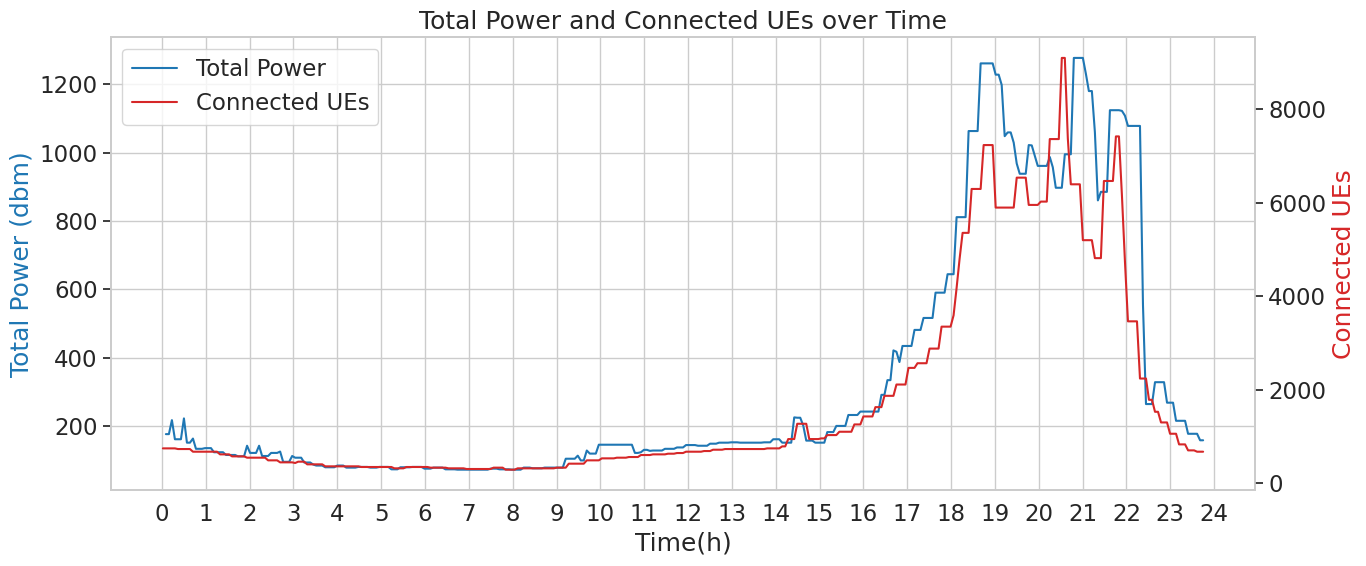

In [116]:
# Align on time
# We'll do an asof merge to interpolate UEs at power timestamps (or vice versa)
# Create uniformly sampled time axis covering both ranges
min_t = min(power_df['time_h'].min(), ues_df['time_h'].min())
max_t = max(power_df['time_h'].max(), ues_df['time_h'].max())

# Resolution: choose the finer of the two mean spacings
power_dt = np.diff(power_df['time_h']).mean() if len(power_df) > 1 else 0.01
ues_dt = np.diff(ues_df['time_h']).mean() if len(ues_df) > 1 else 0.01
step = max(min(power_dt, ues_dt), 0.001)

grid = pd.DataFrame({'time_h': np.arange(min_t, max_t + step/2, step)})

# Interpolate each series onto the grid
power_grid = pd.merge_asof(grid, power_df.sort_values('time_h'), on='time_h')
ues_grid = pd.merge_asof(grid, ues_df.sort_values('time_h'), on='time_h')

merged = grid.join(power_grid[['total_power']], how='left')
merged = merged.join(ues_grid[['connected_ues']], how='left')

# Optional: linear interpolation for smoother plots
merged['total_power'] = merged['total_power'].interpolate()
merged['connected_ues'] = merged['connected_ues'].interpolate()

# Plot with seaborn/matplotlib (style like Plot3)
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
# Remove gridlines for the secondary axis
ax2.grid(False)

sns.lineplot(data=merged, x='time_h', y='total_power', ax=ax1, color='tab:blue', label='Total Power')
sns.lineplot(data=merged, x='time_h', y='connected_ues', ax=ax2, color='tab:red', label='Connected UEs')

ax1.set_xlabel('Time(h)')
# Integer ticks like Plot3
try:
    xmin, xmax = float(merged['time_h'].min()), float(merged['time_h'].max())
    ax1.set_xticks(np.arange(int(np.floor(xmin)), int(np.ceil(xmax)) + 1, 1))
except Exception:
    pass

ax1.set_ylabel('Total Power (dbm)', color='tab:blue')
ax2.set_ylabel('Connected UEs', color='tab:red')
plt.title('Total Power and Connected UEs over Time')

# Combined legend (single box)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# Remove any per-axis legends
for ax in (ax1, ax2):
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()
# Build combined lists and drop no-legend entries
handles = []
labels = []
for h, l in list(zip(handles1, labels1)) + list(zip(handles2, labels2)):
    if not l or l == '_nolegend_' or l in labels:
        continue
    handles.append(h)
    labels.append(l)
ax1.legend(handles, labels, loc='upper left', frameon=True)



plt.tight_layout()
# Save like Plot3
out_dir = base / 'out'
out_dir.mkdir(parents=True, exist_ok=True)

plt.savefig(out_dir / 'power_vs_ues.png', bbox_inches='tight')
plt.savefig(out_dir / 'power_vs_ues.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Notes
- X-axis is hours from the CSVs.
- Total Power is the sum across all `pci_*` columns.
- Connected UEs is taken from the `Connected UEs` column of `input.csv`.
- The series are interpolated onto a common grid for a smooth comparison.

## Zoomed view

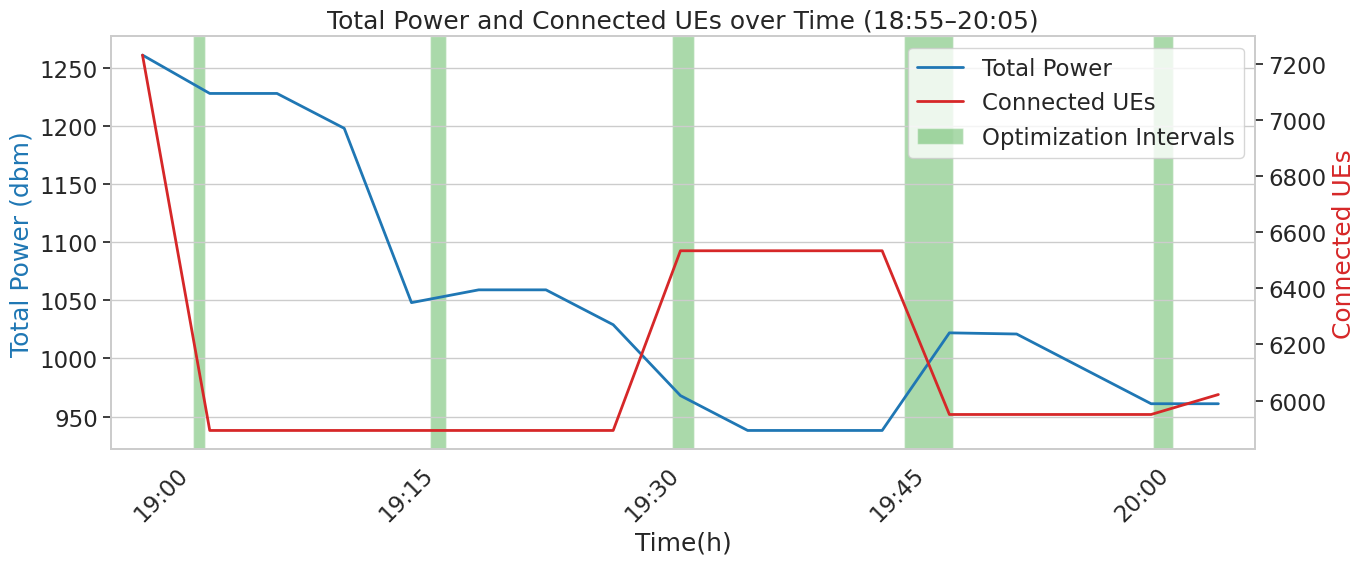

In [117]:
# Filter interval and plot
start_h, end_h = 18 + 55/60, 20 + 5/60  # 18:55 to 20:05
context_pad = 0.0  # no extra context
view_start, view_end = start_h, end_h

# Data slices
focus = merged[(merged['time_h'] >= start_h) & (merged['time_h'] <= end_h)].copy()

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()
# Ensure no gridlines on ax2
ax2.grid(False)

# Emphasized focus lines (18:55–20:05)
sns.lineplot(data=focus, x='time_h', y='total_power', ax=ax1, color='tab:blue', linewidth=2, label='Total Power')
sns.lineplot(data=focus, x='time_h', y='connected_ues', ax=ax2, color='tab:red', linewidth=2, label='Connected UEs')

ax1.set_xlabel('Time(h)')
ax1.set_xlim(view_start, view_end)
# Remove vertical gridlines on primary axis only
ax1.grid(False, axis='x')

# Optimization bars only in 19:00–20:00
opt_window_start, opt_window_end = 19.0, 20.0

# Add optimization intervals centered on five evenly spaced anchors (includes 19:00 and 20:00)
try:
    # Edit this list to control each interval width (in seconds). Will cycle if shorter than available bars.
    opt_durations_sec = [90, 60, 80, 180, 150]
    anchors = np.linspace(opt_window_start, opt_window_end, 5, endpoint=True)
    idx = 0
    for t_anchor in anchors:
        if opt_durations_sec:
            dur_sec = float(opt_durations_sec[idx % len(opt_durations_sec)])
            idx += 1
            half = (dur_sec / 3600.0) / 2.0
            t0 = max(t_anchor - half, opt_window_start)
            t1 = min(t_anchor + half, opt_window_end)
            if t1 > t0:
                ax1.axvspan(t0, t1, facecolor='tab:green', alpha=0.40, zorder=0)
except Exception:
    pass


# X ticks as HH:MM at 15-minute intervals starting at 19:00
tick_start = max(19.0, view_start)
ticks = np.arange(tick_start, view_end + 1e-9, 0.25)
ax1.set_xticks(ticks)
labels = []
for t in ticks:
    h = int(np.floor(t))
    m = int(round((t - h) * 60))
    if m == 60:
        h += 1
        m = 0
    labels.append(f"{h:02d}:{m:02d}")
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Title with HH:MM range (no 'with context')
def _hhmm(x):
    h = int(np.floor(x))
    m = int(round((x - h) * 60))
    if m == 60:
        h += 1
        m = 0
    return f"{h:02d}:{m:02d}"
plt.title(f"Total Power and Connected UEs over Time ({_hhmm(start_h)}–{_hhmm(end_h)})")


ax1.set_ylabel('Total Power (dbm)', color='tab:blue')
ax2.set_ylabel('Connected UEs', color='tab:red')

# Combined legend (single box) with green patch for optimization interval
from matplotlib.patches import Patch
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
for ax in (ax1, ax2):
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()
handles, labels = [], []
for h, l in list(zip(h1, l1)) + list(zip(h2, l2)):
    if not l or l == '_nolegend_' or l in labels:
        continue
    handles.append(h)
    labels.append(l)
opt_patch = Patch(facecolor='tab:green', alpha=0.40, label='Optimization Interval')
if 'Optimization Intervals' not in labels:
    handles.append(opt_patch)
    labels.append('Optimization Intervals')
ax1.legend(handles, labels, loc='upper right', frameon=True)

plt.tight_layout()
# Ensure output directory exists and save zoomed plot
out_dir = base / 'out'
out_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(out_dir / f'power_vs_ues_{start_h}_{end_h}.png', bbox_inches='tight')
plt.savefig(out_dir / f'power_vs_ues_{start_h}_{end_h}.pdf', dpi=300, bbox_inches='tight')
plt.show()